In [1]:
pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 34.4 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
pd.options.mode.chained_assignment = None
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [4]:
df=pd.read_csv('/kaggle/input/dataset/amaretto_dataset_anon.csv.csv')
df.head(10)

,Transaction ID,Originator,Originator_ID,EntryDate,InputOutput,Market,Product ISIN,Product Type,Product Class,Normalized Amount,Currency,Anomaly
0,I9Q3S5YYLCQX,Client_087,_XID,2019-01-01 17:55:33,Sell,Market2,ISN-X01-LRBXBXN,FutureCommodity,Trade,10317357.93,Currency1,0
1,VFZ6INAXVYJV,Client_019,_XID,2019-01-01 18:52:34,Sell,Market1,ISN-X01-856Z8OC,FX,Trade,31042.04,Currency2,0
2,HXOA8DNPX1OE,Client_385,_XID,2019-01-01 15:21:09,Sell,Market1,ISN-X01-5CW2HUF,SimpleTransfer,Trade,35910.53,Currency1,0
3,O9W5IR932XT1,Client_276,_XID,2019-01-01 20:02:36,Sell,Market1,ISN-X01-AQ848H7,FutureEquity,Trade,79630.92,Currency2,0
4,84KF31TPK1LU,Client_049,_XID,2019-01-01 09:06:58,Buy,Market1,ISN-X01-7JWB2C7,FX,Trade,434370.69,Currency1,0
5,A6EAD26IK49P,Client_010,_XID,2019-01-01 09:07:06,Buy,Market4,ISN-X01-U9SBVA7,FX,Trade,431.11,Currency2,0
6,GR4T16G3CJFR,Client_043,_XID,2019-01-01 18:51:21,Sell,Market1,ISN-X01-XLEB16J,FX,Trade,441.55,Currency1,0
7,5PVIQLPTQB9O,Client_033,_XID,2019-01-01 14:12:56,Sell,Market1,ISN-X01-6B2N5M3,FutureOptionEquityIndex,Trade,65399.66,Currency2,0
8,EVQW6NEMUSRK,Client_269,_XID,2019-01-01 20:26:17,Buy,Market1,ISN-X01-UUGSZWQ,FXForward,Trade,370662.13,Currency1,0
9,MC0HQPX4Z4SZ,Client_034,_XID,2019-01-01 14:21:59,Sell,Market1,ISN-X01-QNY2DAD,FutureBond,ADR Conversion,526.67,Currency1,0


In [5]:
df['EntryDate'] = pd.to_datetime(df['EntryDate'])

In [6]:
df.shape[0]

29704090

In [7]:
df2=df.tail(df.shape[0]-20000000)
df=df.head(20000000)

In [8]:
total_transactions_df2 = df2['Transaction ID'].count()
df2['num_transactions_proportion'] = 1 / total_transactions_df2

df2['EntryDate'] = pd.to_datetime(df2['EntryDate'])
df2['Weekday'] = df2['EntryDate'].dt.weekday
df2['Hour'] = df2['EntryDate'].dt.hour

df2['Morning'] = df2['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
df2['Evening'] = df2['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
df2['Night'] = df2['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

condition_round_amount = ((df2['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df2['Normalized Amount'] == df2['Normalized Amount'].round()))
df2['Round_Amount_Condition'] = condition_round_amount.astype(int)

condition_small_amount = ((df2['Normalized Amount'] < 1177.44) & (df2['Normalized Amount'] > 420.65) & (df2['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
df2['Small_Amount_Condition'] = condition_small_amount

condition_sell = df2['InputOutput'] == 'Sell'
df2['Sell_Condition'] = condition_sell
condition_buy = df2['InputOutput'] == 'Buy'
df2['Buy_Condition'] = condition_buy

inoutdelta = (df2['InputOutput'] == 'Buy').astype(int) - (df2['InputOutput'] == 'Sell').astype(int)
df2['InputOutput_Delta'] = inoutdelta

condition_sell_cash = df2['Normalized Amount'].where(condition_sell & (df2['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
df2['condition_sell_cash'] = condition_sell_cash

condition_sell_cash2 = df2['Normalized Amount'].where(condition_sell & (df2['Product Type'] == 'SimpleTransfer'), 0)
df2['condition_sell_cash2'] = condition_sell_cash2

aggregated_dfte = df2.groupby(['Originator','Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
    num_transactions=('num_transactions_proportion', 'sum'),
    total_amount_traded=('Normalized Amount', 'mean'),
    transactions_count_small_amount=('Small_Amount_Condition', 'mean'),
    transactions_count_round_amount=('Round_Amount_Condition', 'mean'),
    transactions_count_amount_sell=('Sell_Condition', 'mean'),
    transactions_count_amount_buy=('Buy_Condition', 'mean'),
    cash_out_withdrawal_security_out=('condition_sell_cash', 'mean'),
    simpletranfer=('condition_sell_cash2', 'mean'),
    inputoutput_delta=('InputOutput_Delta', 'mean')
).reset_index()

df2.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)
    

In [9]:
start_date = '2019-01-01'
end_date = '2019-03-25'
date_range = pd.date_range(start=start_date, end=end_date).date

In [10]:
days=56

In [14]:
f1scorel=[]
accuracy1=[]
tprl=[]
tnrl=[]
fprl=[]
totaltransactions=[]
aggregatedtransactions=[]
reviewedtransactions_total=[]
reviewedtransactions_day=[]

for i in range(1, days):
    n_test = df[df['EntryDate'].dt.date == date_range[i]].shape[0]
    
    if n_test == 0:
        continue
    
    print('Day ',i)
    print('Train transactions from Day 1 to Day ', i, df[df['EntryDate'].dt.date.isin(date_range[:i])].shape[0])
    totaltransactions.append(df[df['EntryDate'].dt.date.isin(date_range[:i])].shape[0])
    #print('Test transactions Day ', i+1, df[df['EntryDate'].dt.date == date_range[i]].shape[0])
    
    df1=df[df['EntryDate'].dt.date.isin(date_range[:i])]
    #df2=df[df['EntryDate'].dt.date == date_range[i]]
    
    # dataframe TRAIN
    
    total_transactions_df1 = df1['Transaction ID'].count()
    df1['num_transactions_proportion'] = 1 / total_transactions_df1

    df1['EntryDate'] = pd.to_datetime(df1['EntryDate'])
    df1['Weekday'] = df1['EntryDate'].dt.weekday
    df1['Hour'] = df1['EntryDate'].dt.hour

    df1['Morning'] = df1['Hour'].apply(lambda x: 1 if 6 <= x < 12 else 0)  # Mañana (6:00 - 11:59)
    df1['Evening'] = df1['Hour'].apply(lambda x: 1 if 12 <= x < 18 else 0)  # Tarde (12:00 - 17:59)
    df1['Night'] = df1['Hour'].apply(lambda x: 1 if 18 <= x < 24 or 0 <= x < 6 else 0)  # Noche (18:00 - 23:59), (00:00 - 5:59)

    condition_round_amount = ((df1['Normalized Amount'].apply(lambda x: str(x).count('000.0')) >= 1) & (df1['Normalized Amount'] == df1['Normalized Amount'].round()))
    df1['Round_Amount_Condition'] = condition_round_amount.astype(int)

    condition_small_amount = ((df1['Normalized Amount'] < 1177.44) & (df1['Normalized Amount'] > 420.65) & (df1['Product Class'] == 'Cash in / out (withdrawal), Security in / out'))
    df1['Small_Amount_Condition'] = condition_small_amount

    condition_sell = df1['InputOutput'] == 'Sell'
    df1['Sell_Condition'] = condition_sell
    condition_buy = df1['InputOutput'] == 'Buy'
    df1['Buy_Condition'] = condition_buy

    inoutdelta = (df1['InputOutput'] == 'Buy').astype(int) - (df1['InputOutput'] == 'Sell').astype(int)
    df1['InputOutput_Delta'] = inoutdelta

    condition_sell_cash = df1['Normalized Amount'].where(condition_sell & (df1['Product Class'] == 'Cash in / out (withdrawal), Security in / out'), 0)
    df1['condition_sell_cash'] = condition_sell_cash

    condition_sell_cash2 = df1['Normalized Amount'].where(condition_sell & (df1['Product Type'] == 'SimpleTransfer'), 0)
    df1['condition_sell_cash2'] = condition_sell_cash2

    aggregated_dftr = df1.groupby(['Originator','Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Anomaly']).agg(
        num_transactions=('num_transactions_proportion', 'sum'),
        total_amount_traded=('Normalized Amount', 'mean'),
        transactions_count_small_amount=('Small_Amount_Condition', 'mean'),
        transactions_count_round_amount=('Round_Amount_Condition', 'mean'),
        transactions_count_amount_sell=('Sell_Condition', 'mean'),
        transactions_count_amount_buy=('Buy_Condition', 'mean'),
        cash_out_withdrawal_security_out=('condition_sell_cash', 'mean'),
        simpletranfer=('condition_sell_cash2', 'mean'),
        inputoutput_delta=('InputOutput_Delta', 'mean')
    ).reset_index()

    df1.drop(columns=['Weekday', 'Hour', 'Morning', 'Evening', 'Night', 'Round_Amount_Condition', 'Small_Amount_Condition', 'Sell_Condition', 'Buy_Condition', 'InputOutput_Delta', 'condition_sell_cash', 'condition_sell_cash2','num_transactions_proportion'], inplace=True)
    
    print ('Aggregated transactions to be reviwed by specialized analysts ', aggregated_dftr.shape[0])
    aggregatedtransactions.append(aggregated_dftr.shape[0])
    
    # dataframe TEST
    
    #-------------------------------------------------------------------------------------------------------------------------------------------------
    
    isolation_forest = IsolationForest(bootstrap=True , contamination=0.01, random_state=42)
    isolation_forest.fit(aggregated_dftr.drop(columns=['Originator','Anomaly']))
    aggregated_dftr['anomaly_score'] = isolation_forest.decision_function(aggregated_dftr.drop(columns=['Originator','Anomaly']))

    top_k_anomalies = 5 # Ajustar
    top_rf_anomalies = aggregated_dftr.nsmallest(top_k_anomalies, 'anomaly_score') ###
    top_rf_anomalies.drop('anomaly_score', axis=1, inplace=True)
    least_rf_anomalies = aggregated_dftr.nlargest(top_k_anomalies, 'anomaly_score') ###
    least_rf_anomalies.drop('anomaly_score', axis=1, inplace=True)
    
    top_s_anomalies = aggregated_dftr.nsmallest(2000, 'anomaly_score')  # Muestras más anómalas de Isolation Forest
    clusterer = HDBSCAN(min_cluster_size=3)
    top_s_anomalies['cluster'] = clusterer.fit_predict(top_s_anomalies.drop(columns=['Originator','anomaly_score','Anomaly']))
    ##top_s_anomalies=top_s_anomalies[top_s_anomalies['cluster']!=-1]
    
    samples_per_cluster = 1  # Ajustar
    samples_diverse = top_s_anomalies.groupby('cluster').apply(lambda x: x.nsmallest(samples_per_cluster, 'anomaly_score')).reset_index(drop=True)
    samples_diverse.drop(columns=['cluster','anomaly_score'], axis=1, inplace=True) ###
    
    combined_samples = pd.concat([top_rf_anomalies, least_rf_anomalies, samples_diverse]).drop_duplicates()
    X_combined = combined_samples.drop(columns=['Originator','Anomaly'])   
    y_combined = combined_samples['Anomaly']
    rf_model = RandomForestClassifier(random_state=42)
    rf_model.fit(X_combined, y_combined)
    aggregated_dftr['rf_score'] = rf_model.predict_proba(aggregated_dftr.drop(columns=['Originator','Anomaly', 'anomaly_score']))[:, 1]
    
    # Seleccionamos muestras con mayor diferencia entre Isolation Forest y Random Forest.
    aggregated_dftr['conflict_score'] = abs(aggregated_dftr['anomaly_score'] - aggregated_dftr['rf_score'])
    conflict_samples_k = 3  # Ajustar
    conflict_samples = aggregated_dftr.nlargest(conflict_samples_k, 'conflict_score')
    conflict_samples.drop(columns=['rf_score','anomaly_score','conflict_score'], axis=1, inplace=True)
    
    # Seleccionamos muestras de mayor incertidumbre.
    aggregated_dftr['entropy_score'] = abs(aggregated_dftr['rf_score'] - 0.5)
    entropy_samples_k = 3 # Ajustar
    entropy_samples = aggregated_dftr.nsmallest(entropy_samples_k, 'entropy_score')
    entropy_samples.drop(columns=['rf_score','anomaly_score','conflict_score','entropy_score'], axis=1, inplace=True)
    
    # Combinamos las muestras obtenidas en el dia o periodo presente.
    combined_samples_f = pd.concat([conflict_samples, entropy_samples, combined_samples]).drop_duplicates() # MUESTRAS QUE REVISA EL ANALISTA.
    reviewedtransactions_day.append(combined_samples_f.shape[0])
    
    # Combinamos todas las muestras actuales y pasadas para asegurar el aprendizaje.
    if i==1:
        combined_samples_final=combined_samples_f
    combined_samples_final = pd.concat([combined_samples_final, combined_samples_f], ignore_index=True).drop_duplicates()
    X_final_selected = combined_samples_final.drop(columns=['Originator','Anomaly'])
    y_final_selected = combined_samples_final['Anomaly']
    
    # Entrenamos el modelo Random Forest final.
    rf_model_final = RandomForestClassifier(random_state=42)
    rf_model_final.fit(X_final_selected, y_final_selected)
    
    # Evaluamos el modelo final con el conjunto de prueba (aggregated_dfte)
    y_pred = rf_model_final.predict(aggregated_dfte.drop(columns=['Originator','Anomaly']))
    conf_matrix = confusion_matrix(aggregated_dfte['Anomaly'], y_pred)
    accuracy = accuracy_score(aggregated_dfte['Anomaly'], y_pred)
    accuracy1.append(accuracy)
    f1 = f1_score(aggregated_dfte['Anomaly'], y_pred, average='macro')
    f1scorel.append(f1)
    
    total_tp = 0
    total_tn = 0
    total_fp = 0
    total_fn = 0
    
    for e in range(conf_matrix.shape[0]):
        tp = conf_matrix[e, e]  # True Positives para la clase i
        fn = conf_matrix[e, :].sum() - tp  # False Negatives para la clase i
        fp = conf_matrix[:, e].sum() - tp  # False Positives para la clase i
        tn = conf_matrix.sum() - (tp + fp + fn)  # True Negatives

        total_tp += tp
        total_fn += fn
        total_fp += fp
        total_tn += tn

    tpr = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0  # True Positive Rate
    tnr = total_tn / (total_tn + total_fp) if (total_tn + total_fp) > 0 else 0  # True Negative Rate
    fpr = total_fp / (total_fp + total_tn) if (total_fp + total_tn) > 0 else 0  # False Positive Rate

    tprl.append(tpr)
    tnrl.append(tnr)
    fprl.append(fpr)
    
    print('Actual aggregated transactions reviwed  by analysts from Day 1 to Day', i, combined_samples_final.shape[0])
    print('Actual aggregated transactions reviwed  by analysts on Day 1', combined_samples_f.shape[0])
    reviewedtransactions_total.append(combined_samples_final.shape[0])
    print('Accuracy ', accuracy)
    print('F1-score ', f1)
    print(conf_matrix)
    print('----------------------------------------------------------------------------------------------------')
    print('                         ')
    
    del aggregated_dftr
    gc.collect()

Day  1
Train transactions from Day 1 to Day  1 580361
Aggregated transactions to be reviwed by specialized analysts  8222
Actual aggregated transactions reviwed  by analysts from Day 1 to Day 1 172
Actual aggregated transactions reviwed  by analysts on Day 1 172
Accuracy  0.9912614458335075
F1-score  0.6133865075725647
[[46809     0     0     0     0     0]
 [   84   242     0     0     0     0]
 [    2     0   293     0     0     0]
 [  134     0     0    32     0     0]
 [   76     0     0     0    40     0]
 [  122     0     0     0     0     0]]
----------------------------------------------------------------------------------------------------
                         
Day  2
Train transactions from Day 1 to Day  2 1093241
Aggregated transactions to be reviwed by specialized analysts  16221
Actual aggregated transactions reviwed  by analysts from Day 1 to Day 2 341
Actual aggregated transactions reviwed  by analysts on Day 1 169
Accuracy  0.9937492160388008
F1-score  0.69625477805

Text(0, 0.5, 'F1 Score')

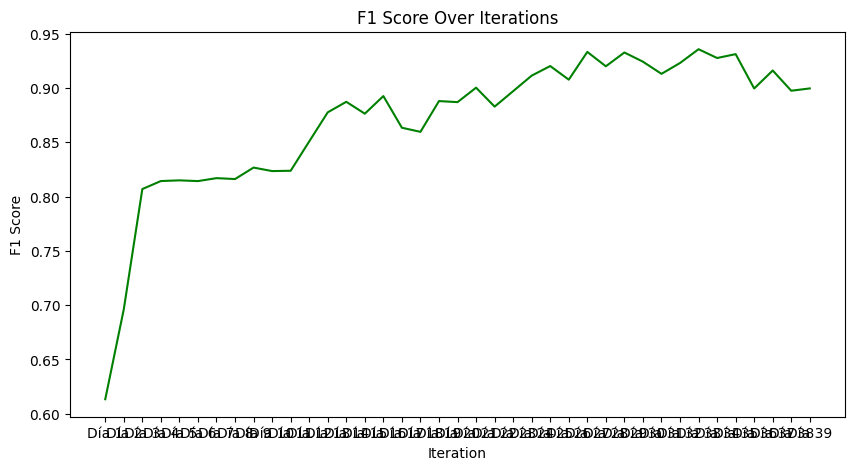

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(f1scorel, color='green')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('F1 Score Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')

Text(0, 0.5, 'True Positive Rate')

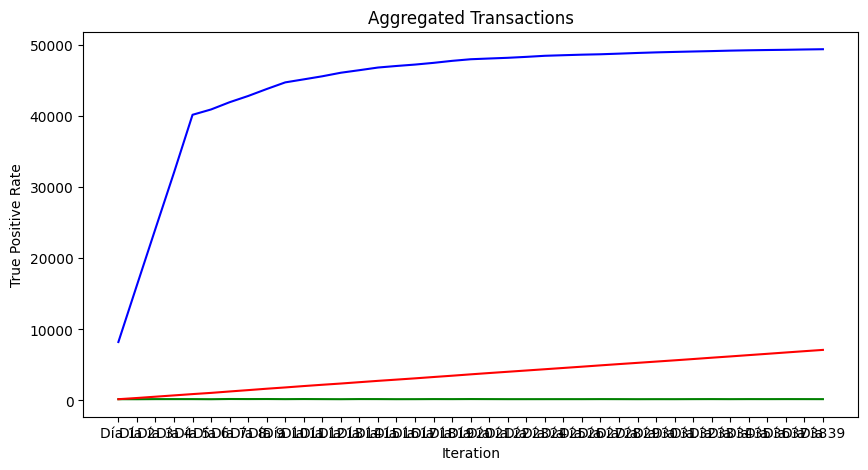

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(aggregatedtransactions, color='blue')
plt.plot(reviewedtransactions_day, color='green')
plt.plot(reviewedtransactions_total, color='red')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('Aggregated Transactions')
plt.xlabel('Iteration')
plt.ylabel('True Positive Rate')


Text(0, 0.5, 'True Positive Rate')

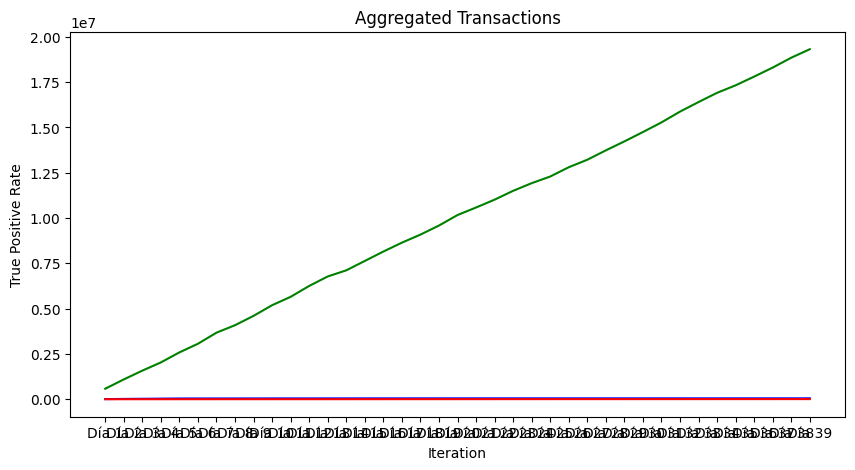

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(aggregatedtransactions, color='blue')
plt.plot(totaltransactions, color='green')
plt.plot(reviewedtransactions_total, color='red')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('Aggregated Transactions')
plt.xlabel('Iteration')
plt.ylabel('True Positive Rate')

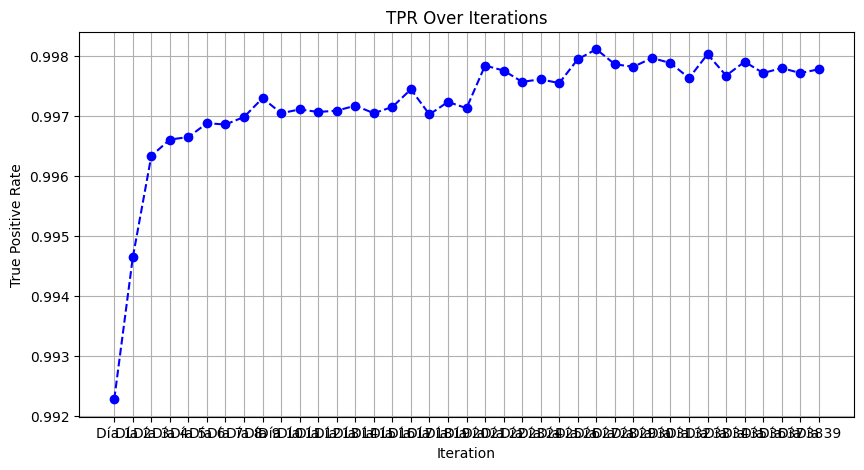

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(tprl, color='blue', linestyle='--', marker='o')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('TPR Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('True Positive Rate')
plt.grid()

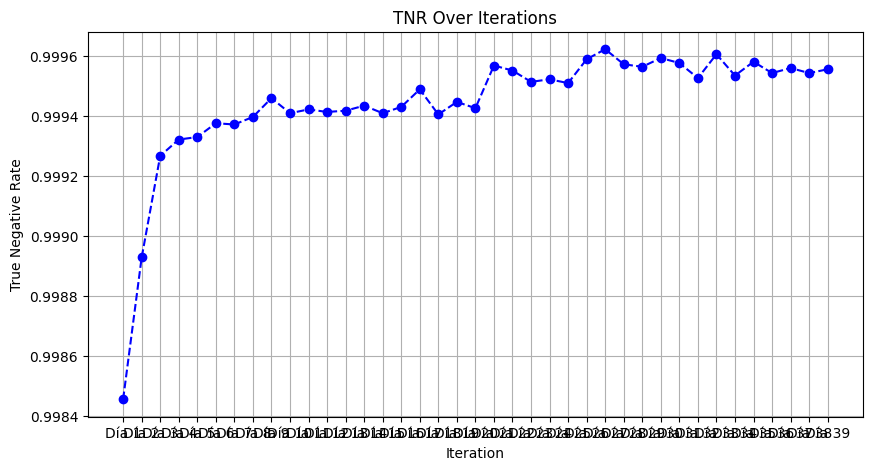

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(tnrl, color='blue', linestyle='--', marker='o')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('TNR Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('True Negative Rate')
plt.grid()

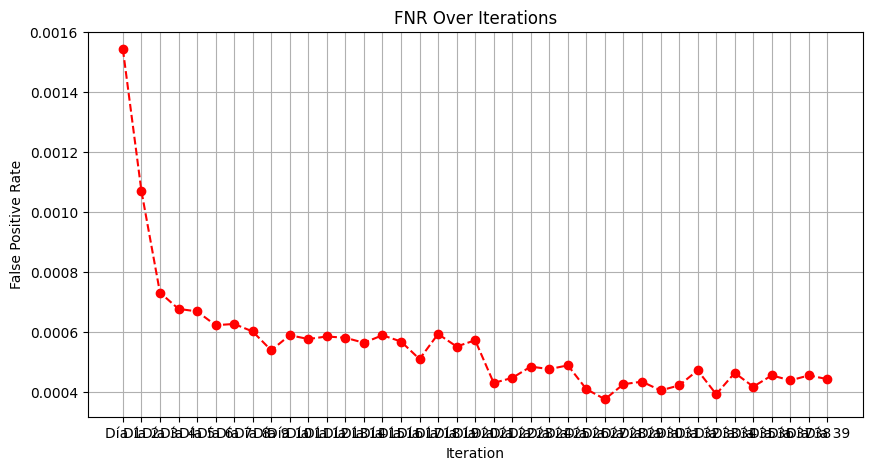

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(fprl, color='red', linestyle='--', marker='o')
plt.xticks(ticks=range(len(f1scorel)), labels=[f'Día {i+1}' for i in range(len(f1scorel))])
plt.title('FNR Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('False Positive Rate')
plt.grid()

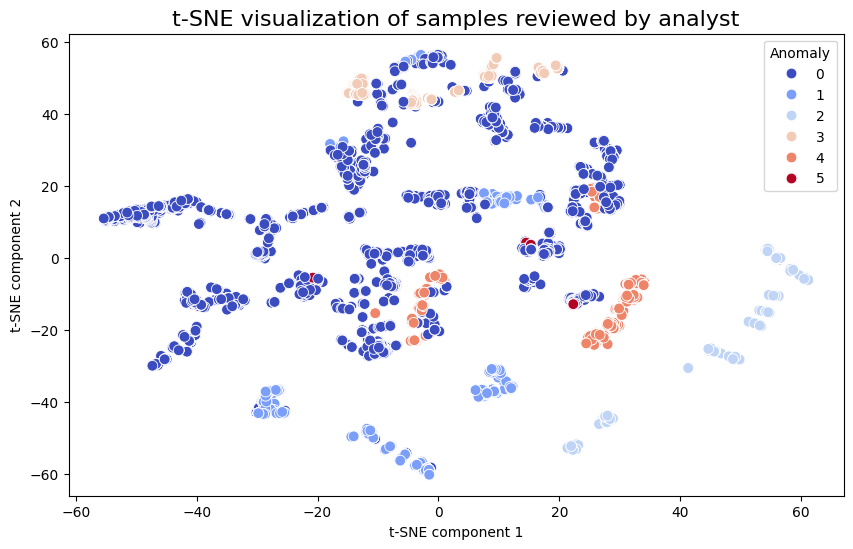

In [17]:

# Asegúrate de tener las características X y las etiquetas y en combined_samples_final
X_final_selected = combined_samples_final.drop(columns=['Originator', 'Anomaly'])
y_final_selected = combined_samples_final['Anomaly']

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final_selected)

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42,perplexity=100)
X_tsne = tsne.fit_transform(X_scaled)

# Graficar con los labels (anomalías o no anomalías)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_final_selected, palette='coolwarm', legend='full', s=60)

# Etiquetas y título del gráfico
plt.title('t-SNE visualization of samples reviewed by analyst', fontsize=16)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(title='Anomaly', loc='upper right')
plt.show()


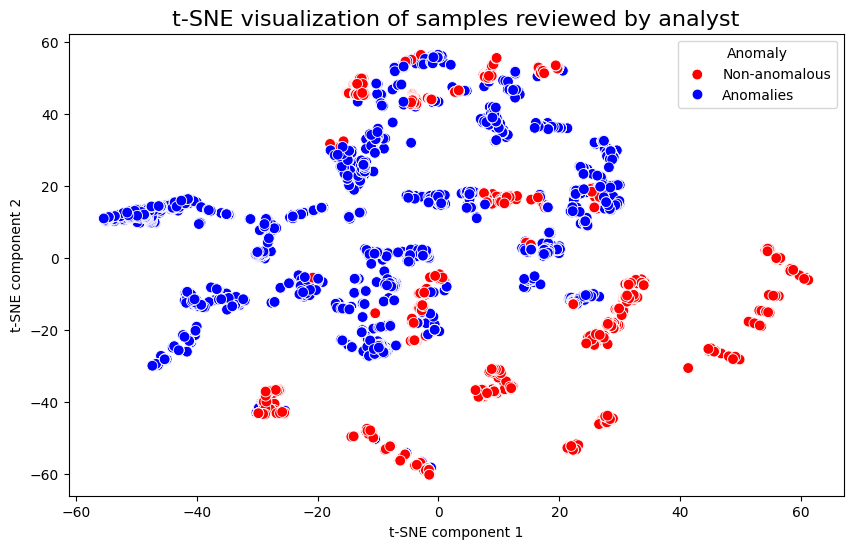

In [23]:
# Crear una nueva columna para diferenciar 0 de los demás valores
y_final_selected_binary = y_final_selected.apply(lambda x: 0 if x == 0 else 1)

# Graficar con los labels (0 como un color, anomalías como otro color)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=y_final_selected_binary, 
    palette={0: 'blue', 1: 'red'},  # 0 en azul, anomalías en rojo
    legend='full', 
    s=60
)

# Etiquetas y título del gráfico
plt.title('t-SNE visualization of samples reviewed by analyst', fontsize=16)
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.legend(title='Anomaly', labels=['Non-anomalous', 'Anomalies'], loc='upper right')
plt.show()